# 0. Setup Paths

In [2]:
import os

In [3]:
CUSTOM_MODEL_NAME = 'my_ssd_mobnet' 
PRETRAINED_MODEL_NAME = 'ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8'
# PRETRAINED_MODEL_NAME = 'ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8'
PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz'
# PRETRAINED_MODEL_URL = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet152_v1_fpn_1024x1024_coco17_tpu-8.tar.gz'
TF_RECORD_SCRIPT_NAME = 'generate_tfrecord.py'
LABEL_MAP_NAME = 'label_map.pbtxt'

In [4]:
paths = {
    'WORKSPACE_PATH': os.path.join('Tensorflow', 'workspace'),
    'SCRIPTS_PATH': os.path.join('Tensorflow','scripts'),
    'APIMODEL_PATH': os.path.join('Tensorflow','models'),
    'ANNOTATION_PATH': os.path.join('Tensorflow', 'workspace','annotations'),
    'IMAGE_PATH': os.path.join('Tensorflow', 'workspace','images', 'strands'),
    'MODEL_PATH': os.path.join('Tensorflow', 'workspace','models'),
    'PRETRAINED_MODEL_PATH': os.path.join('Tensorflow', 'workspace','pre-trained-models'),
    'CHECKPOINT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME), 
    'OUTPUT_PATH': os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'export'), 
    'TFJS_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfjsexport'), 
    'TFLITE_PATH':os.path.join('Tensorflow', 'workspace','models',CUSTOM_MODEL_NAME, 'tfliteexport'), 
    'PROTOC_PATH':os.path.join('Tensorflow','protoc')
 }

paths

{'WORKSPACE_PATH': 'Tensorflow\\workspace',
 'SCRIPTS_PATH': 'Tensorflow\\scripts',
 'APIMODEL_PATH': 'Tensorflow\\models',
 'ANNOTATION_PATH': 'Tensorflow\\workspace\\annotations',
 'IMAGE_PATH': 'Tensorflow\\workspace\\images\\strands',
 'MODEL_PATH': 'Tensorflow\\workspace\\models',
 'PRETRAINED_MODEL_PATH': 'Tensorflow\\workspace\\pre-trained-models',
 'CHECKPOINT_PATH': 'Tensorflow\\workspace\\models\\my_ssd_mobnet',
 'OUTPUT_PATH': 'Tensorflow\\workspace\\models\\my_ssd_mobnet\\export',
 'TFJS_PATH': 'Tensorflow\\workspace\\models\\my_ssd_mobnet\\tfjsexport',
 'TFLITE_PATH': 'Tensorflow\\workspace\\models\\my_ssd_mobnet\\tfliteexport',
 'PROTOC_PATH': 'Tensorflow\\protoc'}

In [5]:
files = {
    'PIPELINE_CONFIG':os.path.join('Tensorflow', 'workspace','models', CUSTOM_MODEL_NAME, 'pipeline.config'),
    'TF_RECORD_SCRIPT': os.path.join(paths['SCRIPTS_PATH'], TF_RECORD_SCRIPT_NAME), 
    'LABELMAP': os.path.join(paths['ANNOTATION_PATH'], LABEL_MAP_NAME)
}

In [5]:
for path in paths.values():
    if not os.path.exists(path):
        if os.name == 'posix':
            !mkdir -p {path}
        if os.name == 'nt':
            !mkdir {path}

# 1. Download TF Models Pretrained Models from Tensorflow Model Zoo and Install TFOD

In [ ]:
# https://www.tensorflow.org/install/source_windows

In [ ]:
if os.name=='nt':
    !pip install wget
    import wget

In [ ]:
if not os.path.exists(os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection')):
    !git clone https://github.com/tensorflow/models {paths['APIMODEL_PATH']}

In [ ]:
# Install Tensorflow Object Detection 
if os.name=='posix':  
    !apt-get install protobuf-compiler
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && cp object_detection/packages/tf2/setup.py . && python -m pip install . 
    
if os.name=='nt':
    url="https://github.com/protocolbuffers/protobuf/releases/download/v3.15.6/protoc-3.15.6-win64.zip"
    wget.download(url)
    !move protoc-3.15.6-win64.zip {paths['PROTOC_PATH']}
    !cd {paths['PROTOC_PATH']} && tar -xf protoc-3.15.6-win64.zip
    os.environ['PATH'] += os.pathsep + os.path.abspath(os.path.join(paths['PROTOC_PATH'], 'bin'))   
    !cd Tensorflow/models/research && protoc object_detection/protos/*.proto --python_out=. && copy object_detection\\packages\\tf2\\setup.py setup.py && python setup.py build && python setup.py install && echo "Baguncinha"
    !cd Tensorflow/models/research/slim && pip install -e . 

In [ ]:
!python 

In [ ]:
VERIFICATION_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'builders', 'model_builder_tf2_test.py')
# Verify Installation
!python {VERIFICATION_SCRIPT}

In [ ]:
!pip install tensorflow==2.13.0

In [ ]:
!pip uninstall protobuf matplotlib -y
!pip install protobuf==3.20.* matplotlib

In [6]:
import object_detection

In [ ]:
!pip list

In [ ]:
if os.name =='posix':
    !wget {PRETRAINED_MODEL_URL}
    !mv {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}
if os.name == 'nt':
    wget.download(PRETRAINED_MODEL_URL)
    !move {PRETRAINED_MODEL_NAME+'.tar.gz'} {paths['PRETRAINED_MODEL_PATH']}
    !cd {paths['PRETRAINED_MODEL_PATH']} && tar -zxvf {PRETRAINED_MODEL_NAME+'.tar.gz'}

# 2. Create Label Map

In [9]:
labels = [{'name':'One', 'id':1}, {'name':'Two', 'id':2}, {'name':'Three', 'id':3}]

with open(files['LABELMAP'], 'w') as f:
    for label in labels:
        f.write('item { \n')
        f.write('\tname:\'{}\'\n'.format(label['name']))
        f.write('\tid:{}\n'.format(label['id']))
        f.write('}\n')

# 3. Create TF records

In [14]:
# OPTIONAL IF RUNNING ON COLAB
ARCHIVE_FILES = os.path.join(paths['IMAGE_PATH'], 'archive.tar.gz')
if os.path.exists(ARCHIVE_FILES):
  !tar -zxvf {ARCHIVE_FILES}

In [13]:
if not os.path.exists(files['TF_RECORD_SCRIPT']):
    !git clone https://github.com/nicknochnack/GenerateTFRecord {paths['SCRIPTS_PATH']}
    
os.path.join(paths['IMAGE_PATH'], 'train')

'Tensorflow\\workspace\\images\\strands\\train'

In [8]:
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'train')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'train.record')} 
!python {files['TF_RECORD_SCRIPT']} -x {os.path.join(paths['IMAGE_PATH'], 'test')} -l {files['LABELMAP']} -o {os.path.join(paths['ANNOTATION_PATH'], 'test.record')} 

Successfully created the TFRecord file: Tensorflow\workspace\annotations\train.record
Successfully created the TFRecord file: Tensorflow\workspace\annotations\test.record


# 4. Copy Model Config to Training Folder

In [9]:
if os.name =='posix':
    !cp {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}
if os.name == 'nt':
    !copy {os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'pipeline.config')} {os.path.join(paths['CHECKPOINT_PATH'])}

        1 arquivo(s) copiado(s).


# 5. Update Config For Transfer Learning

In [10]:
import tensorflow as tf
from object_detection.utils import config_util
from object_detection.protos import pipeline_pb2
from google.protobuf import text_format

In [11]:
config = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])

In [12]:
config

{'model': ssd {
   num_classes: 90
   image_resizer {
     fixed_shape_resizer {
       height: 320
       width: 320
     }
   }
   feature_extractor {
     type: "ssd_mobilenet_v2_fpn_keras"
     depth_multiplier: 1.0
     min_depth: 16
     conv_hyperparams {
       regularizer {
         l2_regularizer {
           weight: 3.9999998989515007e-05
         }
       }
       initializer {
         random_normal_initializer {
           mean: 0.0
           stddev: 0.009999999776482582
         }
       }
       activation: RELU_6
       batch_norm {
         decay: 0.996999979019165
         scale: true
         epsilon: 0.0010000000474974513
       }
     }
     use_depthwise: true
     override_base_feature_extractor_hyperparams: true
     fpn {
       min_level: 3
       max_level: 7
       additional_layer_depth: 128
     }
   }
   box_coder {
     faster_rcnn_box_coder {
       y_scale: 10.0
       x_scale: 10.0
       height_scale: 5.0
       width_scale: 5.0
     }
   }
   matc

In [13]:
pipeline_config = pipeline_pb2.TrainEvalPipelineConfig()
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "r") as f:                                                                                                                                                                                                                     
    proto_str = f.read()                                                                                                                                                                                                                                          
    text_format.Merge(proto_str, pipeline_config)  

In [14]:
pipeline_config.model.ssd.num_classes = len(labels)
pipeline_config.train_config.batch_size = 4
pipeline_config.train_config.fine_tune_checkpoint = os.path.join(paths['PRETRAINED_MODEL_PATH'], PRETRAINED_MODEL_NAME, 'checkpoint', 'ckpt-0')
pipeline_config.train_config.fine_tune_checkpoint_type = "detection"
pipeline_config.train_input_reader.label_map_path= files['LABELMAP']
pipeline_config.train_input_reader.tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'train.record')]
pipeline_config.eval_input_reader[0].label_map_path = files['LABELMAP']
pipeline_config.eval_input_reader[0].tf_record_input_reader.input_path[:] = [os.path.join(paths['ANNOTATION_PATH'], 'test.record')]

In [15]:
config_text = text_format.MessageToString(pipeline_config)                                                                                                                                                                                                        
with tf.io.gfile.GFile(files['PIPELINE_CONFIG'], "wb") as f:                                                                                                                                                                                                                     
    f.write(config_text)   

# 6. Train the model

In [16]:
TRAINING_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'model_main_tf2.py')

In [17]:
command = "python {} --model_dir={} --pipeline_config_path={} --num_train_steps=2000".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'])

In [18]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --num_train_steps=2000


In [18]:
!{command}

^C


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
I0126 16:59:11.718422 23692 mirrored_strategy.py:419] Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
INFO:tensorflow:Maybe overwriting train_steps: 2000
I0126 16:59:11.794422 23692 config_util.py:552] Maybe overwriting train_steps: 2000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0126 16:59:11.794422 23692 config_util.py:552] Maybe overwriting use_bfloat16: False
Instructions for updating:
rename to distribute_datasets_from_function
W0126 16:59:11.819424 23692 deprecation.py:364] From c:\Users\guilh\Documents\TFODCourse\.conda\lib\site-packages\object_detection-0.1-py3.10.egg\object_detection\model_lib_v2.py:563: StrategyBase.experimental_distribute_datasets_from_function (from tensorflow.python.distribute.distribute_lib) is deprecated and will be removed in a future version.
Instructions for updating:
rename to distribute_datasets_from

# 7. Evaluate the Model

In [11]:
command = "python {} --model_dir={} --pipeline_config_path={} --checkpoint_dir={}".format(TRAINING_SCRIPT, paths['CHECKPOINT_PATH'],files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'])

In [12]:
print(command)

python Tensorflow\models\research\object_detection\model_main_tf2.py --model_dir=Tensorflow\workspace\models\my_ssd_mobnet --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet


In [13]:
!{command}

W0214 10:11:15.321817 15388 model_lib_v2.py:1089] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0214 10:11:15.321817 15388 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0214 10:11:15.321817 15388 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0214 10:11:15.322815 15388 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0214 10:11:15.322815 15388 model_lib_v2.py:1106] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\test.record']
I0214 10:11:15.404817 15388 dataset_builder.py:162] Reading unweighted datasets: ['Tensorflow\\workspace\\annotations\\test.record']
INFO:tensorflow:Reading

# 8. Load Train Model From Checkpoint

In [11]:
import os
import tensorflow as tf
from object_detection.utils import label_map_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder
from object_detection.utils import config_util

In [12]:
# Load pipeline config and build a detection model
configs = config_util.get_configs_from_pipeline_file(files['PIPELINE_CONFIG'])
detection_model = model_builder.build(model_config=configs['model'], is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(model=detection_model)
ckpt.restore(os.path.join(paths['CHECKPOINT_PATH'], 'ckpt-51')).expect_partial()

@tf.function
def detect_fn(image):
    image, shapes = detection_model.preprocess(image)
    prediction_dict = detection_model.predict(image, shapes)
    detections = detection_model.postprocess(prediction_dict, shapes)
    return detections

# 9. Detect from an Image

In [13]:
import cv2 
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [14]:
category_index = label_map_util.create_category_index_from_labelmap(files['LABELMAP'])

In [15]:
IMAGE_PATH = os.path.join(paths['IMAGE_PATH'], 'test', '16.png')

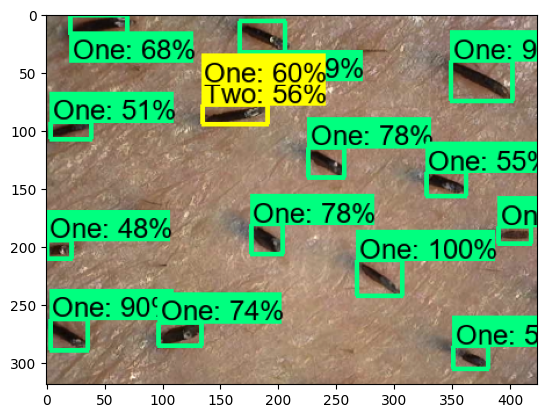

In [16]:
img = cv2.imread(IMAGE_PATH)
image_np = np.array(img)

input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
detections = detect_fn(input_tensor)

num_detections = int(detections.pop('num_detections'))
detections = {key: value[0, :num_detections].numpy()
              for key, value in detections.items()}
detections['num_detections'] = num_detections

# detection_classes should be ints.
detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
            image_np_with_detections,
            detections['detection_boxes'],
            detections['detection_classes']+label_id_offset,
            detections['detection_scores'],
            category_index,
            use_normalized_coordinates=True,
            max_boxes_to_draw=1000,
            min_score_thresh=0.4,
            agnostic_mode=False
            )

plt.imshow(cv2.cvtColor(image_np_with_detections, cv2.COLOR_BGR2RGB))
plt.show()

# 10. Real Time Detections from Webcam

In [ ]:
!pip uninstall opencv-python-headless -y

In [ ]:
cap = cv2.VideoCapture(0)
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

while cap.isOpened(): 
    ret, frame = cap.read()
    image_np = np.array(frame)
    
    input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.float32)
    detections = detect_fn(input_tensor)
    
    num_detections = int(detections.pop('num_detections'))
    detections = {key: value[0, :num_detections].numpy()
                  for key, value in detections.items()}
    detections['num_detections'] = num_detections

    # detection_classes should be ints.
    detections['detection_classes'] = detections['detection_classes'].astype(np.int64)

    label_id_offset = 1
    image_np_with_detections = image_np.copy()

    viz_utils.visualize_boxes_and_labels_on_image_array(
                image_np_with_detections,
                detections['detection_boxes'],
                detections['detection_classes']+label_id_offset,
                detections['detection_scores'],
                category_index,
                use_normalized_coordinates=True,
                max_boxes_to_draw=5,
                min_score_thresh=.8,
                agnostic_mode=False)

    cv2.imshow('object detection',  cv2.resize(image_np_with_detections, (800, 600)))
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        cap.release()
        cv2.destroyAllWindows()
        break

# 10. Freezing the Graph

In [6]:
FREEZE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'exporter_main_v2.py ')

In [7]:
command = "python {} --input_type=image_tensor --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(FREEZE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['OUTPUT_PATH'])

In [8]:
print(command)

python Tensorflow\models\research\object_detection\exporter_main_v2.py  --input_type=image_tensor --pipeline_config_path=Tensorflow\workspace\models\my_ssd_mobnet\pipeline.config --trained_checkpoint_dir=Tensorflow\workspace\models\my_ssd_mobnet --output_directory=Tensorflow\workspace\models\my_ssd_mobnet\export


In [9]:
!{command}

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
W0216 10:18:39.773479  2560 deprecation.py:641] From c:\Users\guilh\Documents\TFODCourse\.conda\lib\site-packages\tensorflow\python\autograph\impl\api.py:459: calling map_fn_v2 (from tensorflow.python.ops.map_fn) with back_prop=False is deprecated and will be removed in a future version.
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
I0216 10:18:43.573220  2560 api.py:460] feature_map_spatial_dims: [(40, 40), (20, 20), (10, 10), (5, 5), (3, 3)]
I0216 10:18:51.959206  2560 api.py:460] feature_map_spatial_dims: [(40, 40), (20, 20), (10, 10), (5, 5), (3, 3)]
I0216 10:18:5

# 11. Conversion to TFJS

In [ ]:
!pip install tensorflowjs

In [25]:
command = "tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default {} {}".format(os.path.join(paths['OUTPUT_PATH'], 'saved_model'), paths['TFJS_PATH'])

In [26]:
print(command)

tensorflowjs_converter --input_format=tf_saved_model --output_node_names='detection_boxes,detection_classes,detection_features,detection_multiclass_scores,detection_scores,num_detections,raw_detection_boxes,raw_detection_scores' --output_format=tfjs_graph_model --signature_name=serving_default Tensorflow\workspace\models\my_ssd_mobnet\export\saved_model Tensorflow\workspace\models\my_ssd_mobnet\tfjsexport


In [ ]:
!{command}

In [ ]:
# Test Code: https://github.com/nicknochnack/RealTimeSignLanguageDetectionwithTFJS

# 12. Conversion to TFLite

In [ ]:
TFLITE_SCRIPT = os.path.join(paths['APIMODEL_PATH'], 'research', 'object_detection', 'export_tflite_graph_tf2.py ')

In [ ]:
command = "python {} --pipeline_config_path={} --trained_checkpoint_dir={} --output_directory={}".format(TFLITE_SCRIPT ,files['PIPELINE_CONFIG'], paths['CHECKPOINT_PATH'], paths['TFLITE_PATH'])

In [ ]:
print(command)

In [ ]:
!{command}

In [ ]:
FROZEN_TFLITE_PATH = os.path.join(paths['TFLITE_PATH'], 'saved_model')
TFLITE_MODEL = os.path.join(paths['TFLITE_PATH'], 'saved_model', 'detect.tflite')

In [ ]:
command = "tflite_convert \
--saved_model_dir={} \
--output_file={} \
--input_shapes=1,300,300,3 \
--input_arrays=normalized_input_image_tensor \
--output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' \
--inference_type=FLOAT \
--allow_custom_ops".format(FROZEN_TFLITE_PATH, TFLITE_MODEL, )

In [ ]:
print(command)

In [ ]:
!{command}

# 13. Zip and Export Models 

In [ ]:
!tar -czf models.tar.gz {paths['CHECKPOINT_PATH']}

In [ ]:
from google.colab import drive
drive.mount('/content/drive')